In [1]:
pip install -U nba_api pandas pyarrow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import time
import numpy as np
import pandas as pd

from nba_api.stats.endpoints import leaguegamefinder

SEASON = "2024-25"      # 2024-25 regular season
SLEEP_S = 1.0
TIMEOUT = 60

In [3]:
# Pull player game logs for the season
# LeagueGameFinder can return Team or Player game logs depending on parameters.
lgf = leaguegamefinder.LeagueGameFinder(
    season_nullable=SEASON,
    league_id_nullable="00",      # NBA
    player_or_team_abbreviation="P",  # Player logs
    timeout=TIMEOUT
)

player_logs = lgf.get_data_frames()[0].copy()
print("raw shape:", player_logs.shape)
print(player_logs.columns.tolist())
player_logs.head()

raw shape: (30000, 30)
['SEASON_ID', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS']


,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,42024,1629026,Kenrich Williams,1610612760,OKC,Oklahoma City Thunder,0042400407,2025-06-22,OKC vs. IND,W,...,NaN,1,0,1,0,0,0,0,0,-1
1,42024,1641767,Ben Sheppard,1610612754,IND,Indiana Pacers,0042400407,2025-06-22,IND @ OKC,L,...,NaN,1,3,4,0,0,0,1,1,-4
2,42024,1630169,Tyrese Haliburton,1610612754,IND,Indiana Pacers,0042400407,2025-06-22,IND @ OKC,L,...,NaN,0,0,0,0,0,0,1,0,-2
3,42024,1631114,Jalen Williams,1610612760,OKC,Oklahoma City Thunder,0042400407,2025-06-22,OKC vs. IND,W,...,0.667,0,4,4,4,2,0,1,4,13
4,42024,1642277,Johnny Furphy,1610612754,IND,Indiana Pacers,0042400407,2025-06-22,IND @ OKC,L,...,NaN,0,0,0,0,0,0,0,0,4


In [4]:
df = player_logs.copy()

# Standardize id/date types
df["GAME_ID"] = df["GAME_ID"].astype(str)
df["GAME_DATE"] = pd.to_datetime(df["GAME_DATE"])

# Convert MIN (can be "MM:SS" or numeric)
def min_to_float(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)
    s = str(x)
    if ":" in s:
        mm, ss = s.split(":")
        try:
            return float(mm) + float(ss)/60.0
        except Exception:
            return np.nan
    try:
        return float(s)
    except Exception:
        return np.nan

df["MIN_FLOAT"] = df["MIN"].apply(min_to_float)

# TS% = PTS / (2*(FGA + 0.44*FTA))
denom = 2.0 * (df["FGA"].astype(float) + 0.44 * df["FTA"].astype(float))
df["TS_PCT"] = np.where(denom > 0, df["PTS"].astype(float) / denom, np.nan)

# Usage proxy per minute (good enough for fatigue modeling)
poss_used = df["FGA"].astype(float) + 0.44 * df["FTA"].astype(float) + df["TOV"].astype(float)
df["USAGE_PROXY_PER_MIN"] = np.where(df["MIN_FLOAT"] > 0, poss_used / df["MIN_FLOAT"], np.nan)

# Keep a clean core
core = df[[
    "GAME_ID", "GAME_DATE",
    "PLAYER_ID", "PLAYER_NAME",
    "TEAM_ID", "TEAM_ABBREVIATION",
    "MIN_FLOAT", "PTS", "FGA", "FTA", "TOV",
    "TS_PCT", "USAGE_PROXY_PER_MIN"
]].copy()

core.to_csv("player_game_core.csv", index=False)
print("Saved player_game_core.csv:", core.shape)
core.head()

Saved player_game_core.csv: (30000, 13)


,GAME_ID,GAME_DATE,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,MIN_FLOAT,PTS,FGA,FTA,TOV,TS_PCT,USAGE_PROXY_PER_MIN
0,0042400407,2025-06-22,1629026,Kenrich Williams,1610612760,OKC,5.0,0,1,0,0,0.000000,0.200000
1,0042400407,2025-06-22,1641767,Ben Sheppard,1610612754,IND,16.0,0,1,0,1,0.000000,0.125000
2,0042400407,2025-06-22,1630169,Tyrese Haliburton,1610612754,IND,7.0,9,5,0,1,0.900000,0.857143
3,0042400407,2025-06-22,1631114,Jalen Williams,1610612760,OKC,38.0,20,20,6,1,0.441696,0.622105
4,0042400407,2025-06-22,1642277,Johnny Furphy,1610612754,IND,1.0,0,0,0,0,NaN,0.000000


In [8]:
core = pd.read_csv("player_game_core.csv", parse_dates=["GAME_DATE"])

core = core.sort_values(["PLAYER_ID", "GAME_DATE"]).reset_index(drop=True)

core["DAYS_SINCE_LAST"] = core.groupby("PLAYER_ID")["GAME_DATE"].diff().dt.days
core["BACK_TO_BACK"] = (core["DAYS_SINCE_LAST"] == 1).astype(int)

# Rolling workload (exclude current game)
core["MIN_LAST_3"] = (
    core.groupby("PLAYER_ID")["MIN_FLOAT"]
        .apply(lambda s: s.shift(1).rolling(3).mean())
        .reset_index(level=0, drop=True)
)

core["MIN_LAST_5"] = (
    core.groupby("PLAYER_ID")["MIN_FLOAT"]
        .apply(lambda s: s.shift(1).rolling(5).mean())
        .reset_index(level=0, drop=True)
)

# FIXED GAMES_LAST_7D (time-aware, per-player)

core = core.sort_values(["PLAYER_ID", "GAME_DATE"]).reset_index(drop=True)

games_last_7d_parts = []

for pid, g in core.groupby("PLAYER_ID", sort=False):
    g = g.sort_values("GAME_DATE").copy()

    # Build a 1-per-game series indexed by GAME_DATE (DatetimeIndex)
    s = pd.Series(1, index=pd.to_datetime(g["GAME_DATE"]))

    # Exclude current game (shift by rows, keeps datetime index)
    s_shift = s.shift(1)

    # Rolling count over last 7 days on DatetimeIndex
    roll_cnt = s_shift.rolling("7D").sum()

    # Map back to the original row indices of g
    out = pd.Series(roll_cnt.to_numpy(), index=g.index)
    games_last_7d_parts.append(out)

core["GAMES_LAST_7D"] = pd.concat(games_last_7d_parts).sort_index()

core.to_csv("player_game_fatigue_features.csv", index=False)
print("Saved player_game_fatigue_features.csv:", core.shape)
core.head(12)

Saved player_game_fatigue_features.csv: (30000, 18)


,GAME_ID,GAME_DATE,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,MIN_FLOAT,PTS,FGA,FTA,TOV,TS_PCT,USAGE_PROXY_PER_MIN,DAYS_SINCE_LAST,BACK_TO_BACK,MIN_LAST_3,MIN_LAST_5,GAMES_LAST_7D
0,12400028,2024-10-10,2544,LeBron James,1610612747,LAL,16.0,11,11,2,2,0.462963,0.867500,NaN,0,NaN,NaN,NaN
1,12400056,2024-10-15,2544,LeBron James,1610612747,LAL,23.0,6,9,0,3,0.333333,0.521739,5.0,0,NaN,NaN,1.0
2,22400062,2024-10-22,2544,LeBron James,1610612747,LAL,35.0,16,16,1,2,0.486618,0.526857,7.0,0,NaN,NaN,1.0
3,22400085,2024-10-25,2544,LeBron James,1610612747,LAL,35.0,21,13,8,2,0.635593,0.529143,3.0,0,24.666667,NaN,2.0
4,22400096,2024-10-26,2544,LeBron James,1610612747,LAL,34.0,32,22,4,5,0.673401,0.845882,1.0,1,31.000000,NaN,3.0
5,22400111,2024-10-28,2544,LeBron James,1610612747,LAL,36.0,11,14,6,2,0.330529,0.517778,2.0,0,34.666667,28.6,4.0
6,22400118,2024-10-30,2544,LeBron James,1610612747,LAL,29.0,26,13,7,6,0.808458,0.761379,2.0,0,35.000000,32.6,4.0
7,22400137,2024-11-01,2544,LeBron James,1610612747,LAL,36.0,27,17,6,0,0.687373,0.545556,2.0,0,33.000000,33.8,4.0
8,22400156,2024-11-04,2544,LeBron James,1610612747,LAL,40.0,20,16,5,1,0.549451,0.480000,3.0,0,33.666667,34.0,3.0
9,22400174,2024-11-06,2544,LeBron James,1610612747,LAL,35.0,39,24,4,5,0.756988,0.878857,2.0,0,35.000000,35.0,3.0


In [11]:
fat = pd.read_csv("player_game_fatigue_features.csv", parse_dates=["GAME_DATE"])

team_adv = pd.read_csv("player_box_advanced_v3_raw.csv").copy()
team_adv = team_adv.rename(columns={
    "gameId": "GAME_ID",
    "teamId": "TEAM_ID",
    "pace": "PACE",
    "estimatedPace": "PACE_EST"
})
team_adv["GAME_ID"] = team_adv["GAME_ID"].astype(str)

# keep only what we need
keep_cols = ["GAME_ID", "TEAM_ID"]
for c in ["PACE", "PACE_EST", "possessions"]:
    if c in team_adv.columns:
        keep_cols.append(c)

team_adv_small = team_adv[keep_cols].drop_duplicates()

# --- FIX dtype mismatch before merge (GAME_ID int vs str) ---

# Ensure both join keys match dtypes
fat["GAME_ID"] = fat["GAME_ID"].astype(str)
team_adv_small["GAME_ID"] = team_adv_small["GAME_ID"].astype(str)

# TEAM_ID sometimes also mismatches; normalize too
fat["TEAM_ID"] = fat["TEAM_ID"].astype(int)
team_adv_small["TEAM_ID"] = team_adv_small["TEAM_ID"].astype(int)

# Now merge
fat = fat.merge(team_adv_small, on=["GAME_ID", "TEAM_ID"], how="left")

fat.to_csv("player_game_fatigue_features_with_pace.csv", index=False)
print("Saved player_game_fatigue_features_with_pace.csv:", fat.shape)
fat.head()

Saved player_game_fatigue_features_with_pace.csv: (30000, 21)


,GAME_ID,GAME_DATE,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,MIN_FLOAT,PTS,FGA,FTA,...,TS_PCT,USAGE_PROXY_PER_MIN,DAYS_SINCE_LAST,BACK_TO_BACK,MIN_LAST_3,MIN_LAST_5,GAMES_LAST_7D,PACE,PACE_EST,possessions
0,12400028,2024-10-10,2544,LeBron James,1610612747,LAL,16.0,11,11,2,...,0.462963,0.867500,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
1,12400056,2024-10-15,2544,LeBron James,1610612747,LAL,23.0,6,9,0,...,0.333333,0.521739,5.0,0,NaN,NaN,1.0,NaN,NaN,NaN
2,22400062,2024-10-22,2544,LeBron James,1610612747,LAL,35.0,16,16,1,...,0.486618,0.526857,7.0,0,NaN,NaN,1.0,94.5,18.9,95.0
3,22400085,2024-10-25,2544,LeBron James,1610612747,LAL,35.0,21,13,8,...,0.635593,0.529143,3.0,0,24.666667,NaN,2.0,101.5,20.3,101.0
4,22400096,2024-10-26,2544,LeBron James,1610612747,LAL,34.0,32,22,4,...,0.673401,0.845882,1.0,1,31.000000,NaN,3.0,106.5,21.3,107.0


In [12]:
import pandas as pd

df = pd.read_csv("player_game_fatigue_features_with_pace.csv", parse_dates=["GAME_DATE"])

print(df.shape)
print(df.columns.tolist())

df[[
    "PLAYER_ID",
    "GAME_DATE",
    "MIN_FLOAT",
    "TS_PCT",
    "USAGE_PROXY_PER_MIN",
    "DAYS_SINCE_LAST",
    "BACK_TO_BACK",
    "MIN_LAST_3",
    "MIN_LAST_5",
    "GAMES_LAST_7D",
    "PACE"
]].head(10)

(30000, 21)
['GAME_ID', 'GAME_DATE', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'MIN_FLOAT', 'PTS', 'FGA', 'FTA', 'TOV', 'TS_PCT', 'USAGE_PROXY_PER_MIN', 'DAYS_SINCE_LAST', 'BACK_TO_BACK', 'MIN_LAST_3', 'MIN_LAST_5', 'GAMES_LAST_7D', 'PACE', 'PACE_EST', 'possessions']


,PLAYER_ID,GAME_DATE,MIN_FLOAT,TS_PCT,USAGE_PROXY_PER_MIN,DAYS_SINCE_LAST,BACK_TO_BACK,MIN_LAST_3,MIN_LAST_5,GAMES_LAST_7D,PACE
0,2544,2024-10-10,16.0,0.462963,0.867500,NaN,0,NaN,NaN,NaN,NaN
1,2544,2024-10-15,23.0,0.333333,0.521739,5.0,0,NaN,NaN,1.0,NaN
2,2544,2024-10-22,35.0,0.486618,0.526857,7.0,0,NaN,NaN,1.0,94.5
3,2544,2024-10-25,35.0,0.635593,0.529143,3.0,0,24.666667,NaN,2.0,101.5
4,2544,2024-10-26,34.0,0.673401,0.845882,1.0,1,31.000000,NaN,3.0,106.5
5,2544,2024-10-28,36.0,0.330529,0.517778,2.0,0,34.666667,28.6,4.0,96.5
6,2544,2024-10-30,29.0,0.808458,0.761379,2.0,0,35.000000,32.6,4.0,NaN
7,2544,2024-11-01,36.0,0.687373,0.545556,2.0,0,33.000000,33.8,4.0,NaN
8,2544,2024-11-04,40.0,0.549451,0.480000,3.0,0,33.666667,34.0,3.0,NaN
9,2544,2024-11-06,35.0,0.756988,0.878857,2.0,0,35.000000,35.0,3.0,NaN


In [13]:
import pandas as pd
import numpy as np

PATH = "player_game_fatigue_features_with_pace.csv"
df = pd.read_csv(PATH)

df["GAME_DATE"] = pd.to_datetime(df["GAME_DATE"])
df = df.sort_values(["PLAYER_ID", "GAME_DATE"]).reset_index(drop=True)

# TS denominator (controls noise: tiny sample games produce weird TS%)
df["TS_DENOM"] = 2 * (df["FGA"] + 0.44 * df["FTA"])

In [14]:
# Prior mean TS (expanding) — shifted to avoid leakage
df["TS_PRIOR_MEAN"] = (
    df.groupby("PLAYER_ID", group_keys=False)["TS_PCT"]
      .apply(lambda s: s.shift(1).expanding(min_periods=5).mean())
)

df["TS_DELTA"] = df["TS_PCT"] - df["TS_PRIOR_MEAN"]

# Filter out very noisy games (recommended)
model_df = df[
    (df["MIN_FLOAT"] >= 8) &          # played enough
    (df["TS_DENOM"] >= 10) &          # enough shooting volume
    (df["TS_DELTA"].notna())
].copy()

print("Model rows:", model_df.shape)
print(model_df[["TS_PCT","TS_PRIOR_MEAN","TS_DELTA"]].describe())

Model rows: (18923, 24)
             TS_PCT  TS_PRIOR_MEAN      TS_DELTA
count  18923.000000   18923.000000  18923.000000
mean       0.574588       0.563811      0.010776
std        0.192402       0.064778      0.195260
min        0.000000       0.119048     -0.708240
25%        0.453092       0.529298     -0.109863
50%        0.576369       0.565026      0.007788
75%        0.697970       0.603932      0.131227
max        1.416667       0.955695      0.962653


In [15]:
cutoff = model_df["GAME_DATE"].quantile(0.80)

train = model_df[model_df["GAME_DATE"] < cutoff].copy()
test  = model_df[model_df["GAME_DATE"] >= cutoff].copy()

print(train.shape, test.shape, cutoff)

(15103, 24) (3820, 24) 2025-03-23 00:00:00


In [16]:
FEATURES_A = [
    "MIN_FLOAT", "MIN_LAST_3", "MIN_LAST_5",
    "GAMES_LAST_7D", "BACK_TO_BACK", "DAYS_SINCE_LAST",
    "USAGE_PROXY_PER_MIN", "PACE"
]

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

FEATURES = FEATURES_A  # switch to FEATURES_B if you want pre-game

X_train = train[FEATURES]
y_train = train["TS_DELTA"]
X_test  = test[FEATURES]
y_test  = test["TS_DELTA"]

# --- Ridge w/ time-series CV
ridge = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", Ridge())
])

param_grid = {"model__alpha": [0.1, 1, 5, 10, 25, 50, 100]}
tscv = TimeSeriesSplit(n_splits=5)

g = GridSearchCV(ridge, param_grid, cv=tscv, scoring="neg_mean_absolute_error", n_jobs=1)
g.fit(X_train, y_train)
ridge_best = g.best_estimator_

pred_r = ridge_best.predict(X_test)
print("RIDGE best:", g.best_params_)
print("RIDGE MAE:", mean_absolute_error(y_test, pred_r))
rmse = np.sqrt(mean_squared_error(y_test, pred_r))
print("RIDGE RMSE:", rmse)
print("RIDGE R2:", r2_score(y_test, pred_r))

# --- Nonlinear model
hgb = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", HistGradientBoostingRegressor(
        max_depth=3, learning_rate=0.1, max_iter=150, max_bins=64, random_state=0
    ))
])
hgb.fit(X_train, y_train)
pred_h = hgb.predict(X_test)
print("\nHGB MAE:", mean_absolute_error(y_test, pred_h))
rmse_h = np.sqrt(mean_squared_error(y_test, pred_h))
print("HGB RMSE:", rmse_h)
print("HGB R2:", r2_score(y_test, pred_h))

RIDGE best: {'model__alpha': 100}
RIDGE MAE: 0.14820248933207755
RIDGE RMSE: 0.1908250259371504
RIDGE R2: 0.012175656095404386

HGB MAE: 0.14734199010769516
HGB RMSE: 0.19011387701593407
HGB R2: 0.01952460024508318


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

# Define "bad game" threshold
y_train_bin = (y_train <= -0.05).astype(int)
y_test_bin  = (y_test  <= -0.05).astype(int)

clf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000))
])

clf.fit(X_train, y_train_bin)
proba = clf.predict_proba(X_test)[:, 1]

print("Base rate (bad games):", y_test_bin.mean())
print("ROC AUC:", roc_auc_score(y_test_bin, proba))
print("Avg Precision:", average_precision_score(y_test_bin, proba))

Base rate (bad games): 0.37198952879581154
ROC AUC: 0.5737456874917681
Avg Precision: 0.4301226805349957


In [21]:
coef = ridge_best.named_steps["model"].coef_
coef_df = pd.DataFrame({"feature": FEATURES, "coef": coef}).sort_values("coef")
print(coef_df)

               feature      coef
2           MIN_LAST_5 -0.025268
1           MIN_LAST_3 -0.013444
4         BACK_TO_BACK -0.004092
7                 PACE -0.000299
6  USAGE_PROXY_PER_MIN  0.000671
5      DAYS_SINCE_LAST  0.001141
3        GAMES_LAST_7D  0.003652
0            MIN_FLOAT  0.037887


In [22]:
coef = clf.named_steps["model"].coef_[0]
coef_df = pd.DataFrame({"feature": FEATURES, "coef": coef}).sort_values("coef")
print(coef_df)

               feature      coef
0            MIN_FLOAT -0.424570
6  USAGE_PROXY_PER_MIN -0.128458
3        GAMES_LAST_7D -0.018482
7                 PACE -0.018461
5      DAYS_SINCE_LAST  0.004947
4         BACK_TO_BACK  0.048049
1           MIN_LAST_3  0.064242
2           MIN_LAST_5  0.254658


In [23]:
# Pregame Fatigue Risk

import pandas as pd
import numpy as np

df = pd.read_csv(
    "player_game_fatigue_features_with_pace.csv",
    parse_dates=["GAME_DATE"]
)

df = df.sort_values(["PLAYER_ID", "GAME_DATE"]).reset_index(drop=True)

In [25]:
# Shift workload features so they are PRE-GAME
LAG_COLS = [
    "MIN_LAST_3",
    "MIN_LAST_5",
    "GAMES_LAST_7D",
    "USAGE_PROXY_PER_MIN",
    "PACE",
    "DAYS_SINCE_LAST",
    "BACK_TO_BACK"
]

for c in LAG_COLS:
    df[f"{c}_PRE"] = df.groupby("PLAYER_ID")[c].shift(1)

# Build rolling usage (pre-game)

df["USAGE_LAST_5_PRE"] = (
    df.groupby("PLAYER_ID")["USAGE_PROXY_PER_MIN"]
      .transform(lambda s: s.shift(1).rolling(5).mean())
)

In [27]:
# Prior baseline TS (no leakage)
df["TS_PRIOR_MEAN"] = (
    df.groupby("PLAYER_ID")["TS_PCT"]
      .transform(lambda s: s.shift(1).expanding(min_periods=5).mean())
)

df["TS_DELTA"] = df["TS_PCT"] - df["TS_PRIOR_MEAN"]

# Binary fatigue outcome (what teams like)
df["BAD_GAME"] = (df["TS_DELTA"] <= -0.05).astype(int)

In [28]:
FEATURES_PRE = [
    "MIN_LAST_3_PRE",
    "MIN_LAST_5_PRE",
    "GAMES_LAST_7D_PRE",
    "BACK_TO_BACK_PRE",
    "DAYS_SINCE_LAST_PRE",
    "USAGE_LAST_5_PRE",
    "PACE_PRE",
]

model_df = df[
    (df["TS_PRIOR_MEAN"].notna()) &
    (df["BAD_GAME"].notna())
].copy()

X = model_df[FEATURES_PRE]
y = model_df["BAD_GAME"]

print("Rows:", model_df.shape)
print("Base rate:", y.mean())

Rows: (26754, 32)
Base rate: 0.3815130447783509


In [29]:
cutoff = model_df["GAME_DATE"].quantile(0.80)

train = model_df[model_df["GAME_DATE"] < cutoff]
test  = model_df[model_df["GAME_DATE"] >= cutoff]

X_train, y_train = train[FEATURES_PRE], train["BAD_GAME"]
X_test,  y_test  = test[FEATURES_PRE],  test["BAD_GAME"]

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

clf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=3000))
])

clf.fit(X_train, y_train)

proba = clf.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, proba))
print("Avg Precision:", average_precision_score(y_test, proba))

ROC AUC: 0.5076710291471195
Avg Precision: 0.3835891322725682


In [31]:
coef = clf.named_steps["model"].coef_[0]
coef_df = pd.DataFrame({
    "feature": FEATURES_PRE,
    "coef": coef
}).sort_values("coef")

print(coef_df)

               feature      coef
5     USAGE_LAST_5_PRE -0.065656
4  DAYS_SINCE_LAST_PRE -0.015947
6             PACE_PRE -0.014856
3     BACK_TO_BACK_PRE -0.014190
1       MIN_LAST_5_PRE -0.010200
2    GAMES_LAST_7D_PRE -0.001354
0       MIN_LAST_3_PRE  0.032101


In [35]:
test["RISK_BUCKET_3"] = pd.qcut(
    test["FATIGUE_RISK"],
    q=[0, 0.33, 0.66, 1.0],
    labels=["Low", "Medium", "High"]
)

summary3 = (
    test.groupby("RISK_BUCKET_3", observed=True)
        .agg(
            games=("FATIGUE_RISK","size"),
            bad_rate=("BAD_GAME","mean")
        )
)

print(summary3)

               games  bad_rate
RISK_BUCKET_3                 
Low             1768  0.368213
Medium          1767  0.395020
High            1821  0.382208


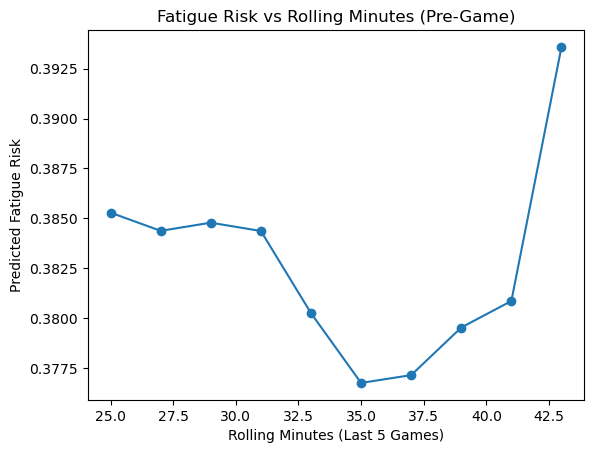

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bin rolling minutes
bins = np.arange(24, 46, 2)
test["MIN_LAST_5_BIN"] = pd.cut(test["MIN_LAST_5_PRE"], bins)

curve = (
    test.groupby("MIN_LAST_5_BIN", observed=True)
        .agg(
            risk=("FATIGUE_RISK", "mean"),
            games=("FATIGUE_RISK", "size")
        )
        .reset_index()
)

# Midpoints for plotting
curve["bin_mid"] = curve["MIN_LAST_5_BIN"].apply(lambda x: x.mid)

plt.figure()
plt.plot(curve["bin_mid"], curve["risk"], marker="o")
plt.xlabel("Rolling Minutes (Last 5 Games)")
plt.ylabel("Predicted Fatigue Risk")
plt.title("Fatigue Risk vs Rolling Minutes (Pre-Game)")
plt.show()

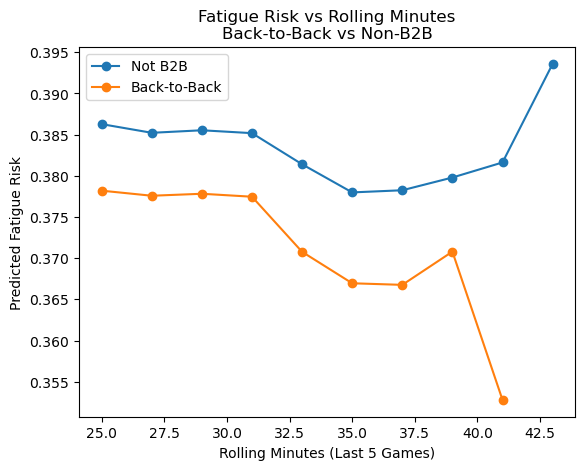

In [37]:
curve_b2b = (
    test.groupby(
        ["MIN_LAST_5_BIN", "BACK_TO_BACK_PRE"],
        observed=True
    )
    .agg(risk=("FATIGUE_RISK","mean"))
    .reset_index()
)

for b2b_val, label in [(0, "Not B2B"), (1, "Back-to-Back")]:
    sub = curve_b2b[curve_b2b["BACK_TO_BACK_PRE"] == b2b_val]
    plt.plot(
        sub["MIN_LAST_5_BIN"].apply(lambda x: x.mid),
        sub["risk"],
        marker="o",
        label=label
    )

plt.xlabel("Rolling Minutes (Last 5 Games)")
plt.ylabel("Predicted Fatigue Risk")
plt.title("Fatigue Risk vs Rolling Minutes\nBack-to-Back vs Non-B2B")
plt.legend()
plt.show()

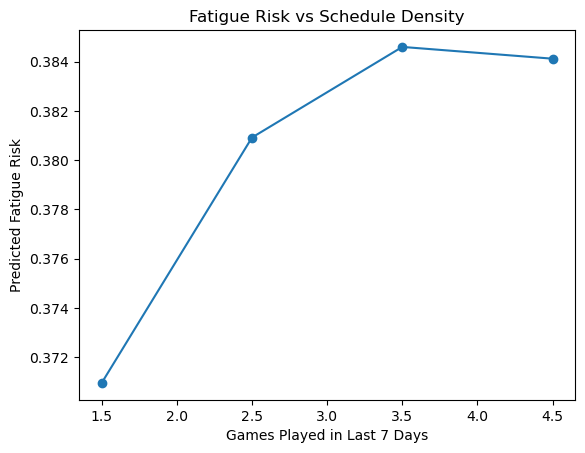

In [38]:
bins = [0, 1, 2, 3, 4, 5]
test["GAMES_7D_BIN"] = pd.cut(test["GAMES_LAST_7D_PRE"], bins, right=False)

curve_7d = (
    test.groupby("GAMES_7D_BIN", observed=True)
        .agg(
            risk=("FATIGUE_RISK","mean"),
            games=("FATIGUE_RISK","size")
        )
        .reset_index()
)

curve_7d["bin_mid"] = curve_7d["GAMES_7D_BIN"].apply(lambda x: x.mid)

plt.figure()
plt.plot(curve_7d["bin_mid"], curve_7d["risk"], marker="o")
plt.xlabel("Games Played in Last 7 Days")
plt.ylabel("Predicted Fatigue Risk")
plt.title("Fatigue Risk vs Schedule Density")
plt.show()

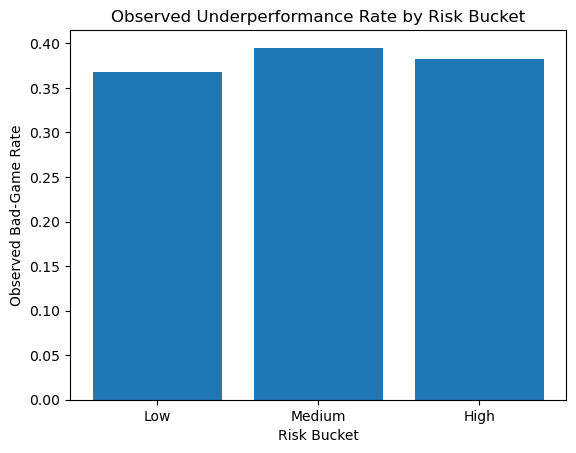

In [39]:
bucket_summary = (
    test.groupby("RISK_BUCKET_3", observed=True)
        .agg(
            risk=("FATIGUE_RISK","mean"),
            bad_rate=("BAD_GAME","mean"),
            games=("FATIGUE_RISK","size")
        )
        .reset_index()
)

plt.figure()
plt.bar(bucket_summary["RISK_BUCKET_3"], bucket_summary["bad_rate"])
plt.xlabel("Risk Bucket")
plt.ylabel("Observed Bad-Game Rate")
plt.title("Observed Underperformance Rate by Risk Bucket")
plt.show()